# LodgIQ Take Home Assessment
### By Justin Jimenez
### 2/11/2022

# 1.0 Table of Contents <a id='Table_of_Contents'>
* [1.0 Table of Contents](#Table_of_Contents)  
* [1.1 Description](#Description)    
* [1.2 Scope Requirements](#Scope_Requirements) 
* [1.3 Data Dictionary](#Data_Dictionary)  
* [1.4 Importing](#Importing)
* [1.5 Data Cleanliness Assessment](#Data_Cleanliness_Assessment)
* [1.6 Exploratory Data Analysis](#EDA)
    * [1.6.1 Correlation Matrix](#Correlation_Matrix)
    * [1.6.2 Market Occupation](#Market_Occupation)
        * [1.6.2.1 Stationarity](#1.6.2.1_Stationarity)
        * [1.6.2.2 Decomposition](#1.6.2.2_Decomposition)
        * [1.6.2.3 Summary Statistics](#1.6.2.3_Summary_Statistics)
    * [1.6.3 ADR](#ADR)
        * [1.6.3.1 Stationarity](#1.6.3.1_Stationarity)
        * [1.6.3.2 Decomposition](#1.6.3.2_Decomposition)
        * [1.6.3.3 Summary Statistics](#1.6.3.3_Summary_Statistics)
    * [1.6.4 RevPAR](#RevPAR)
        * [1.6.4.1 Stationarity](#1.6.4.1_Stationarity)
        * [1.6.4.2 Decomposition](#1.6.4.2_Decomposition)
        * [1.6.4.3 Summary Statistics](#1.6.4.3_Summary_Statistics)
* [1.7 Preprocessing](#Preprocessing)
    * [1.7.1 Creating Stationarity](#Creating_Stationarity)
* [1.8 Model Development](#Model_Development)
    * [1.8.1 Autocorrelation](#Autocorrelation)
    * [1.8.2 ARIMA Model](#ARIMA_Model)
    * [1.8.3 Forecasting](#Forecasting)
* [1.9 Summary](#Summary)
* [1.10 Citations & License](#Citations_License)
    
    
# 1.1 Description <a id='Description'>
[1.0 Table of Contents](#Table_of_Contents) 

The dataset provided is a sample of actualized occupancy, ADR, and RevPAR data from 2018-03-01 to 2021-12-31 on an undisclosed hotel market (e.g. SF, LA, NY, etc.). LodgIQ would like an analysis of patterns in the data along with visualizations and a model to forecast future occupancy.

# 1.2 Scope Requirements <a id='Scope_Requirements'>
[1.0 Table of Contents](#Table_of_Contents) 

1.	The two main goals are to (A) provide an analysis (EDA) and visualization of patterns and/or relationships in the data provided, and (B) develop a model that will forecast the market occupancy (the occ feature in the dataset) for the next 365 days (2022 calendar year).
2.	The deliverables are (1) Jupyter notebook, (1) write-up regarding pattern visualizations, (1) write-up regarding the forecasting model, and (1) write-up regarding things that could/should be done with more time.
3.	These deliverables are expected on or before next Friday, 2/18. The assessment is expected to take around 2 hours.

# 1.3 Data Dictionary <a id='Data_Dictionary'>
[1.0 Table of Contents](#Table_of_Contents) 
    
* stay_date = Date of arrival
* occ = Percentage of rooms sold in the city
* adr = Average rate rooms were sold in market
* revpar = Revenue per Available Room in market

# 1.4 Importing <a id='Importing'>
[1.0 Table of Contents](#Table_of_Contents) 

In [2]:
import pandas as pd
import numpy as np
import bamboolib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import kpss, adfuller
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [3]:
market = pd.read_csv('market.csv')

# 1.5 Data Cleanliness Assessment <a id='Data_Cleanliness_Assessment'>
[1.0 Table of Contents](#Table_of_Contents) 

There are no null observations in the dataset. The stay_date feature was changed to a DateTime datatype.

In [4]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401 entries, 0 to 1400
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   stay_date  1401 non-null   object 
 1   occ        1401 non-null   float64
 2   adr        1401 non-null   float64
 3   revpar     1401 non-null   float64
dtypes: float64(3), object(1)
memory usage: 43.9+ KB


In [5]:
market.describe()

,occ,adr,revpar
count,1401.000000,1401.000000,1401.000000
mean,0.590814,228.738633,158.678388
std,0.344515,84.568521,118.913296
min,0.022706,103.380565,2.712649
25%,0.202607,140.459131,25.532530
50%,0.731095,229.762673,162.055643
75%,0.920651,289.312420,253.709687
max,1.045192,527.157875,544.524998


In [6]:
missing = pd.concat([market.isnull().sum().sort_values(ascending = False), 100 * market.isnull().mean().sort_values(ascending = False)], axis=1)
missing.columns=['count', '%']
print(missing)

           count    %
stay_date      0  0.0
occ            0  0.0
adr            0  0.0
revpar         0  0.0


In [7]:
market['stay_date'] = pd.to_datetime(market['stay_date'], infer_datetime_format=True)
market

,stay_date,occ,adr,revpar
0,2018-03-01,0.874524,215.932333,188.838079
1,2018-03-02,0.899531,197.135094,177.329213
2,2018-03-03,0.838585,201.118114,168.654686
3,2018-03-04,0.762481,212.537298,162.055643
4,2018-03-05,0.831692,253.831953,211.110073
...,...,...,...,...
1396,2021-12-27,0.604845,325.360273,196.792469
1397,2021-12-28,0.554664,332.491924,184.421176
1398,2021-12-29,0.530664,339.950188,180.399286
1399,2021-12-30,0.596610,362.866735,216.489797


In [8]:
market = market.rename(columns={'stay_date': 'index'})
market.set_index('index', inplace=True)

# 1.6 Exploratory Data Analysis <a id='EDA'>

## 1.6.1 Correlation Matrix <a id='Correlation_Matrix'>
[1.0 Table of Contents](#Table_of_Contents) 

The correlation matrix reveals some relationships that we might deduce from a basic understanding of supply and demand. The market occupation has a strong positive correlation (0.94) with RevPAR, reflecting an increase in price to match the market supply of available rooms. The market occupation also has a strong negative correlation with ADR, reflecting the decrease in bookings as supply becomes limited.

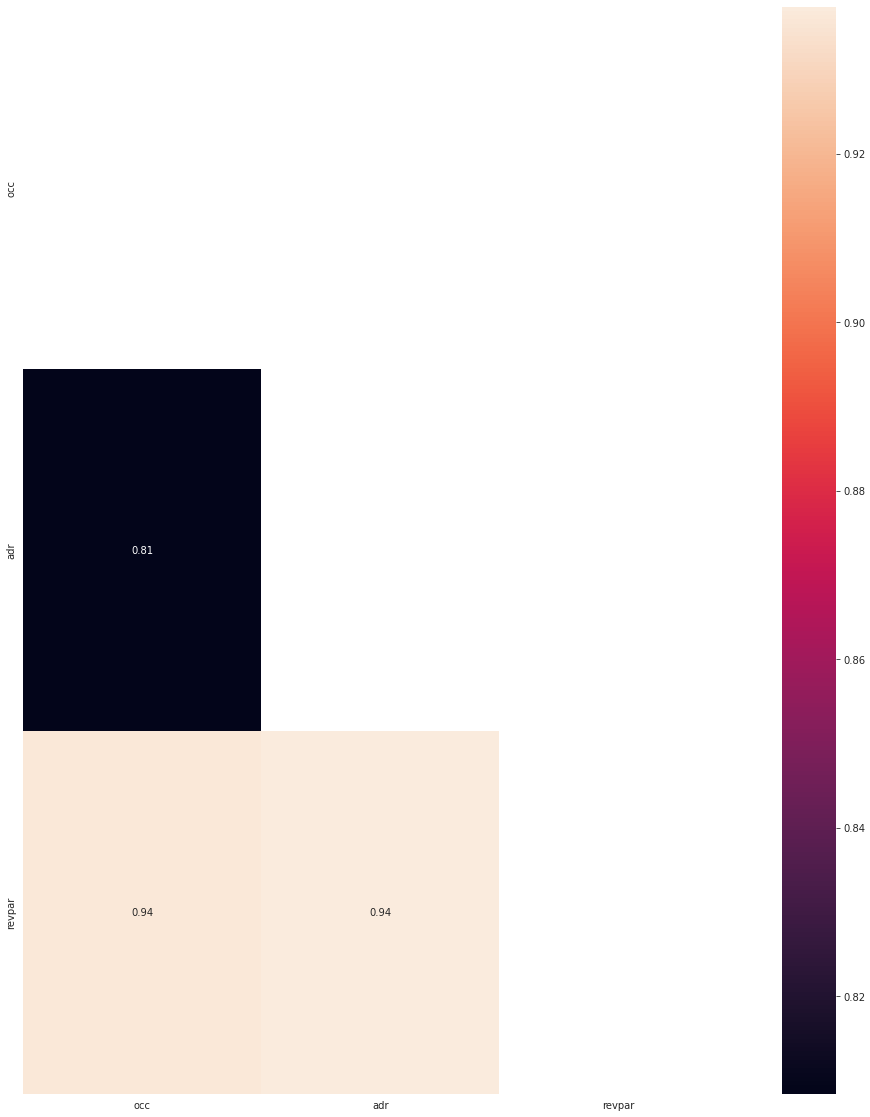

In [9]:
corr = market.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 20))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, annot=True)

The following chart shows the scaled values for all three time series to visualize the strong relationships between them.

In [10]:
scaler = StandardScaler()
market_scaled = pd.DataFrame(scaler.fit_transform(market))
market_scaled.set_index(market.index, inplace=True)
market_scaled.columns = market.columns

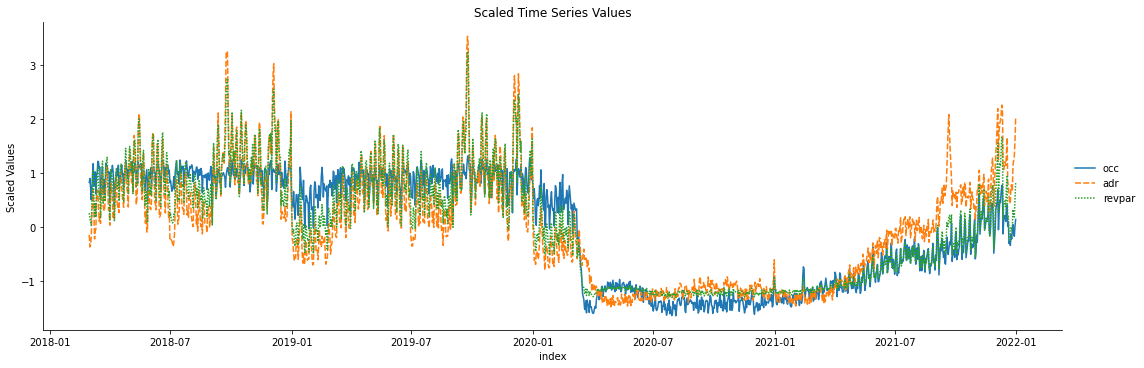

In [11]:
sns.relplot(data=market_scaled, kind='line', aspect = 3, color='g')
plt.ylabel('Scaled Values')
plt.title('Scaled Time Series Values')
plt.show()

## 1.6.2 Market Occupation - Target Feature <a id='Market_Occupation'>

Definition: Percentage of rooms sold in the city.

## 1.6.2.1 Stationarity <a id='1.6.2.1_Stationarity'>
[1.0 Table of Contents](#Table_of_Contents) 

Visualizing the market occupation on a daily frequency reveals some interesting trends. The market appeared to be fairly stable, with a consistant mean and variation. Since the pandemic, the market occupation rate has stayed low, but the rolling average is steadly increasing towards pre-pandemic levels. The variance in occupation was also low during the early months of the pandemic, but has been increasing in recent months.

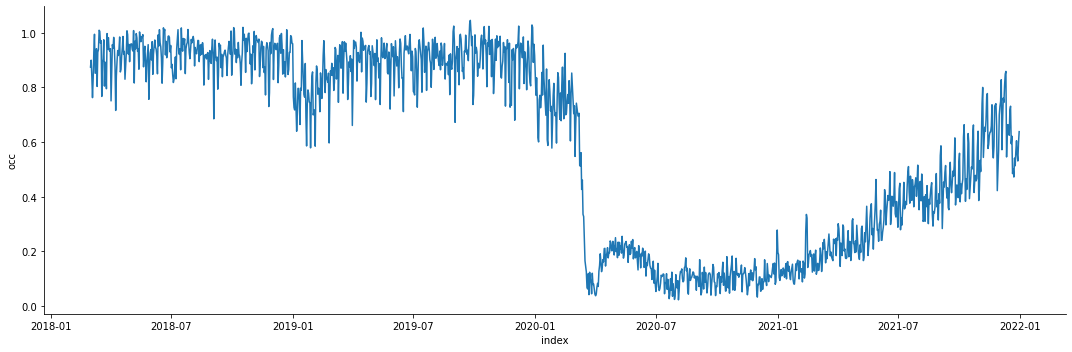

In [12]:
sns.relplot(x='index', y='occ', data=market, kind='line', aspect = 3)

The KPSS and ADFuller tests can be used to evaluate stationarity. The p-values of the two tests (0.01 and 0.6) suggest that the series is not stationary. This will be handled in a later step.

In [13]:
kpss(market.occ)

(3.7580426466113646,
 0.01,
 24,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [14]:
adfuller(market.occ)

(-1.3552125211563322,
 0.603549669310485,
 24,
 1376,
 {'1%': -3.4351112943902695,
  '5%': -2.8636427603069,
  '10%': -2.5678895068491414},
 -3976.157979263693)

## 1.6.2.2 Decomposition<a id='1.6.2.2_Decomposition'>
[1.0 Table of Contents](#Table_of_Contents) 
    
The market occupation data can be decomposed to visualize the overall trend, seasonality, and random noise. The following plots visualize these elements on a monthly basis (period = 30 days).

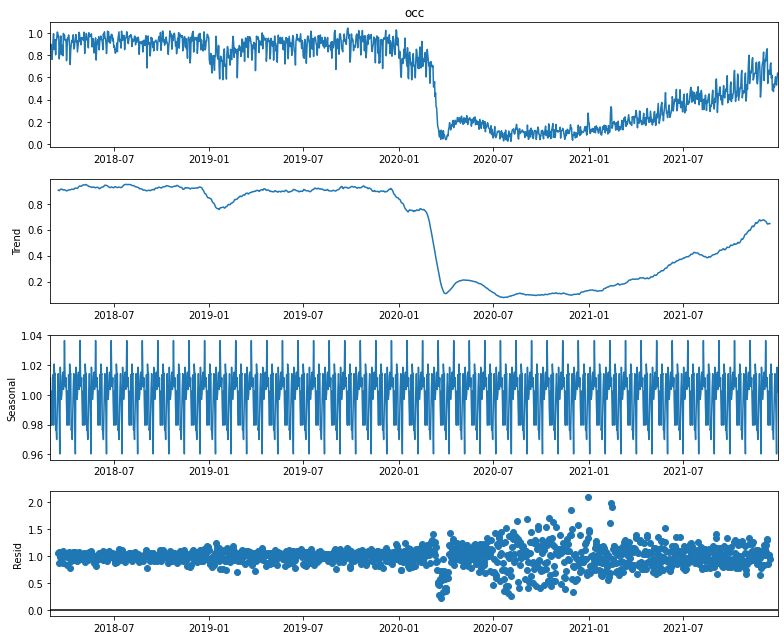

In [15]:
rcParams['figure.figsize'] = 11,9
decomp = sm.tsa.seasonal_decompose(market['occ'], period = 30, model = 'multiplicative')
decomp.plot()
plt.show()

## 1.6.2.3 Summary Statistics<a id='1.6.2.3_Summary_Statistics'>
[1.0 Table of Contents](#Table_of_Contents) 

The following table summarizes statistics for the market occupation rate on an annual basis.

In [16]:
index_year = market.index.year
occ_stats_yearly = market.groupby(index_year).agg({'occ': ['min', 'max', 'mean', 'median', 'std', 'var']})
occ_stats_yearly.columns = ['_'.join(multi_index) for multi_index in occ_stats_yearly.columns.ravel()]
occ_stats_yearly = occ_stats_yearly.reset_index()
occ_stats_yearly

,index,occ_min,occ_max,occ_mean,occ_median,occ_std,occ_var
0,2018,0.684952,1.019638,0.923199,0.933737,0.059877,0.003585
1,2019,0.578734,1.045192,0.885148,0.906945,0.086262,0.007441
2,2020,0.022706,0.954724,0.245293,0.135964,0.250268,0.062634
3,2021,0.079902,0.858528,0.363345,0.359786,0.179106,0.032079


## 1.6.3 ADR<a id='ADR'>

Definition: Average rate rooms were sold in market.

## 1.6.3.1 Stationarity<a id='1.6.3.1_Stationarity'>
[1.0 Table of Contents](#Table_of_Contents) 
    
The ADR shows a similar plummet as a result of the pandemic, with significantly greater volatility pre-pandemic compared to the market occupation. The variance in ADR appears to be regaining its volatility in recent months. The statistical test results also suggest non-stationarity.

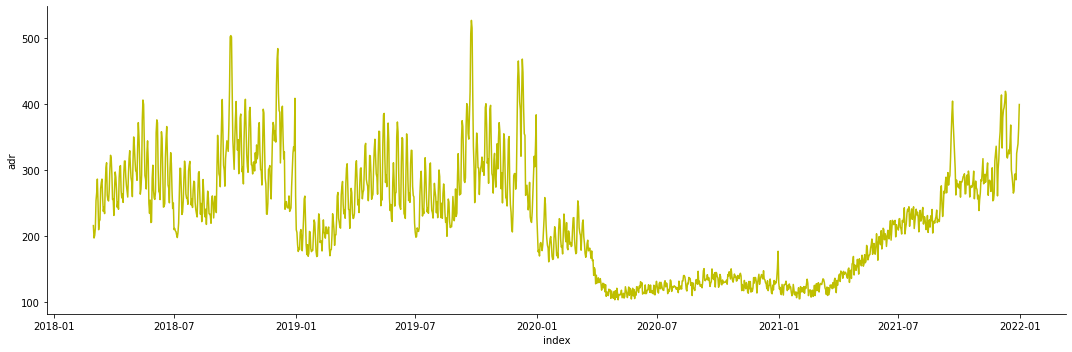

In [17]:
sns.relplot(x='index', y='adr', data=market, kind='line', aspect = 3, color='y')

In [18]:
kpss(market.adr)

(1.8831147105664268,
 0.01,
 24,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [19]:
adfuller(market.adr)

(-1.7207125253557771,
 0.42047359346640273,
 23,
 1377,
 {'1%': -3.4351078301822016,
  '5%': -2.8636412316027577,
  '10%': -2.5678886927682663},
 11949.522340655505)

## 1.6.3.2 Decomposition<a id='1.6.3.2_Decomposition'>
[1.0 Table of Contents](#Table_of_Contents) 

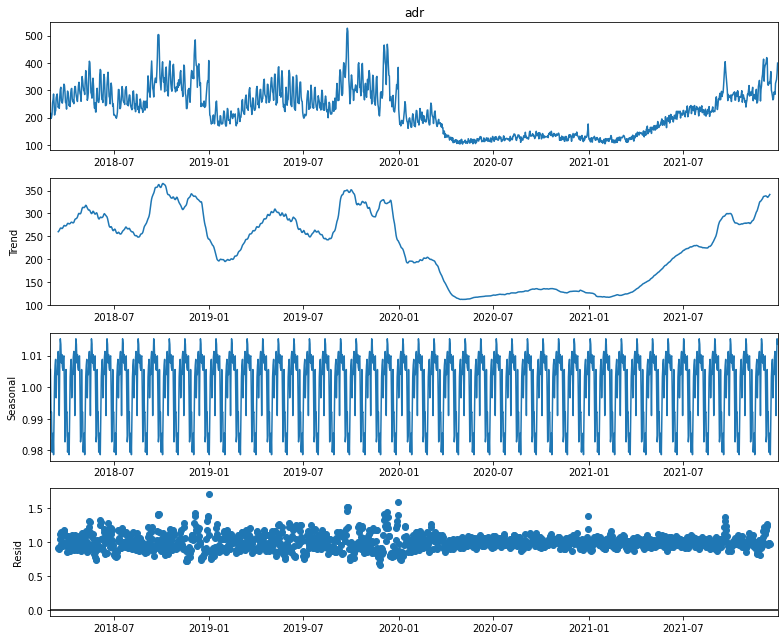

In [20]:
rcParams['figure.figsize'] = 11,9
decomp = sm.tsa.seasonal_decompose(market['adr'], period = 30, model = 'multiplicative')
decomp.plot()
plt.show()

## 1.6.3.3 Summary Statistics<a id='1.6.3.3_Summary_Statistics'>
[1.0 Table of Contents](#Table_of_Contents) 

In [21]:
index_year = market.index.year
adr_stats_yearly = market.groupby(index_year).agg({'adr': ['min', 'max', 'mean', 'median', 'std', 'var']})
adr_stats_yearly.columns = ['_'.join(multi_index) for multi_index in adr_stats_yearly.columns.ravel()]
adr_stats_yearly = adr_stats_yearly.reset_index()
adr_stats_yearly

,index,adr_min,adr_max,adr_mean,adr_median,adr_std,adr_var
0,2018,197.135094,504.043026,297.288400,292.912120,56.398317,3180.770108
1,2019,168.991231,527.157875,274.910327,265.228974,63.490790,4031.080453
2,2020,103.380565,258.469132,142.228840,130.210431,32.733105,1071.456193
3,2021,104.846122,419.644614,211.607611,212.126607,76.501841,5852.531752


## 1.6.4 RevPAR<a id='RevPAR'>

Definition: Revenue per Available Room in market

## 1.6.4.1 Stationarity<a id='1.6.4.1_Stationarity'>
[1.0 Table of Contents](#Table_of_Contents) 
    
The findings for RevPAR are nearly identical to the findings for ADR, which makes sense since the two are tightly correlated.

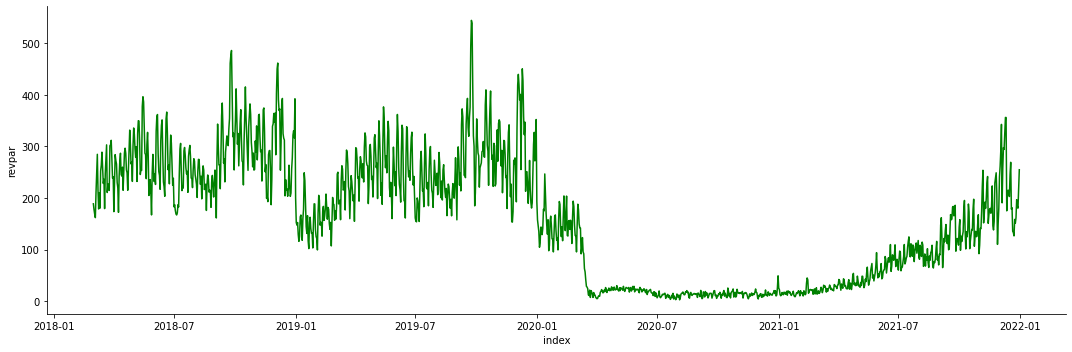

In [22]:
sns.relplot(x='index', y='revpar', data=market, kind='line', aspect = 3, color='g')

In [23]:
kpss(market.revpar)

(3.329057511647124,
 0.01,
 24,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [24]:
adfuller(market.revpar)

(-1.5711465127093245,
 0.4980693440373251,
 22,
 1378,
 {'1%': -3.4351043710114393,
  '5%': -2.863639705119746,
  '10%': -2.5678878798704923},
 12853.331734666714)

## 1.6.4.2 Decomposition<a id='1.6.4.2_Decomposition'>
[1.0 Table of Contents](#Table_of_Contents) 

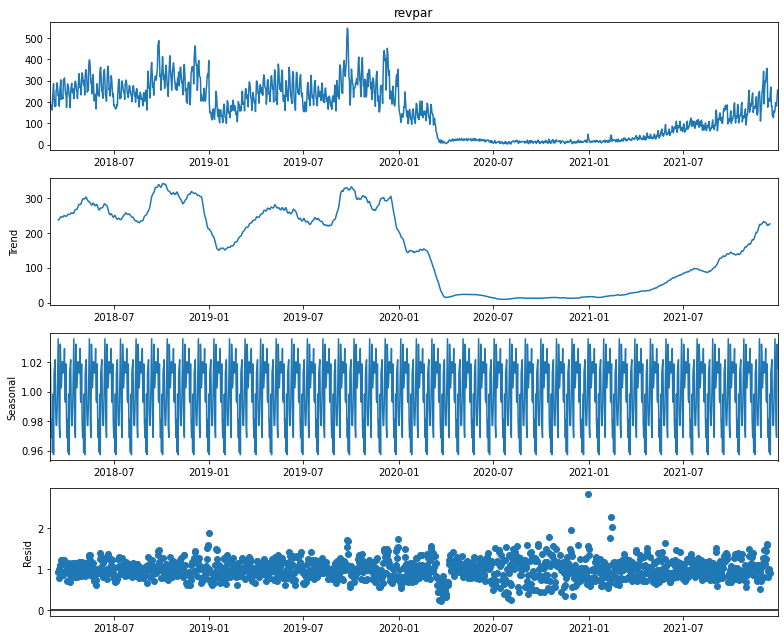

In [25]:
rcParams['figure.figsize'] = 11,9
decomp = sm.tsa.seasonal_decompose(market['revpar'], period = 30, model = 'multiplicative')
decomp.plot()
plt.show()

## 1.6.4.3 Summary Statistics<a id='1.6.4.3_Summary_Statistics'>
[1.0 Table of Contents](#Table_of_Contents) 

In [26]:
index_year = market.index.year
revpar_stats_yearly = market.groupby(index_year).agg({'revpar': ['min', 'max', 'mean', 'median', 'std', 'var']})
revpar_stats_yearly.columns = ['_'.join(multi_index) for multi_index in revpar_stats_yearly.columns.ravel()]
revpar_stats_yearly = revpar_stats_yearly.reset_index()
revpar_stats_yearly

,index,revpar_min,revpar_max,revpar_mean,revpar_median,revpar_std,revpar_var
0,2018,161.426513,486.149526,275.832280,268.657513,61.399277,3769.871239
1,2019,99.459921,544.524998,246.766495,240.995609,73.578815,5413.842021
2,2020,2.712649,246.766652,41.609710,17.333222,54.016488,2917.781009
3,2021,8.855319,356.285348,89.442273,75.707780,70.902446,5027.156843


# 1.7 Preprocessing<a id='Preprocessing'>

## 1.7.1 Creating Stationarity<a id='Creating_Stationarity'>
[1.0 Table of Contents](#Table_of_Contents) 
    
The initial assessment of the market occupation series was that it was not stationary. To transform it into a stationary series, I created a natural log transform and took the first difference. The resulting KPSS and ADFuller tests support the hypothesis that the series is now stationary.

(2.8747023516959374,
 0.01,
 24,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

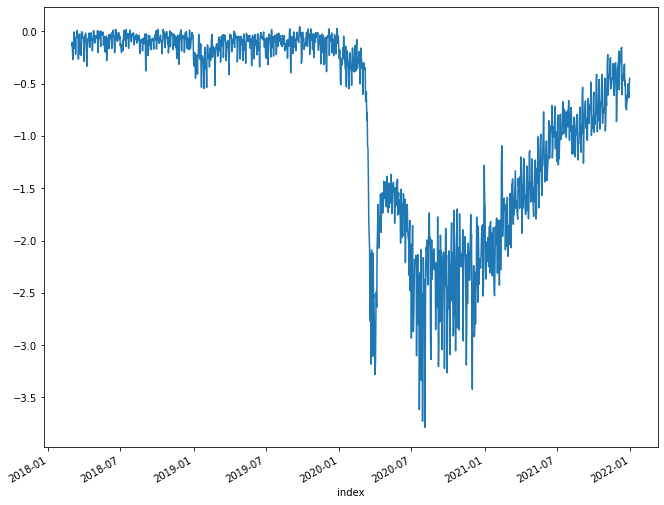

In [27]:
market_log = np.log(market)
market_log.occ.plot()
kpss(market_log.occ)

(-8.439012535952077,
 1.784125901302601e-13,
 20,
 1379,
 {'1%': -3.4351009168670035,
  '5%': -2.863638180853028,
  '10%': -2.5678870681532424},
 -576.9032300428003)

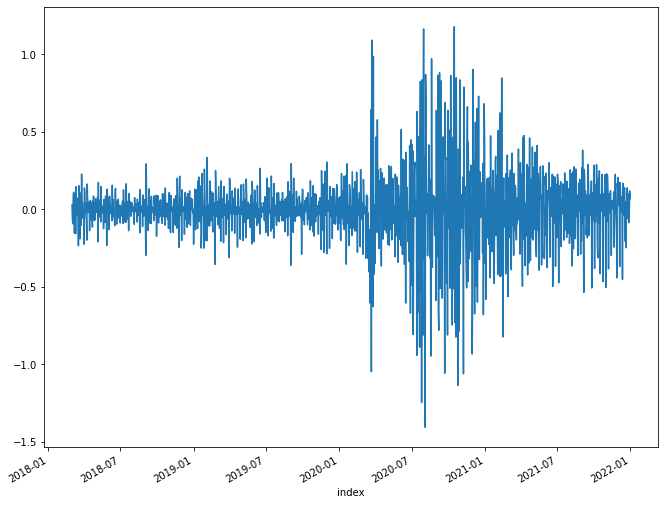

In [28]:
market_log_diff = market_log.diff().dropna()
market_log_diff.occ.plot()
adfuller(market_log_diff.occ)

In [29]:
kpss(market_log_diff.occ)

(0.0897614007825526,
 0.1,
 24,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

# 1.8 Model Development<a id='Model_Development'>

## 1.8.1 Autocorrelation<a id='Autocorrelation'>
[1.0 Table of Contents](#Table_of_Contents) 

I plotted the autocorrelation and partial autocorrelation to try to identify ideal lag values for an ARMA model. The results from the two plots do not reveal any strong evidence for a particular set of lag values, but it does reveal a seasonal pattern recurring every seven days. 

Note: The high autocorrelation coefficients outside the margins of uncertainty indicate a statistically significant autocorrelation.

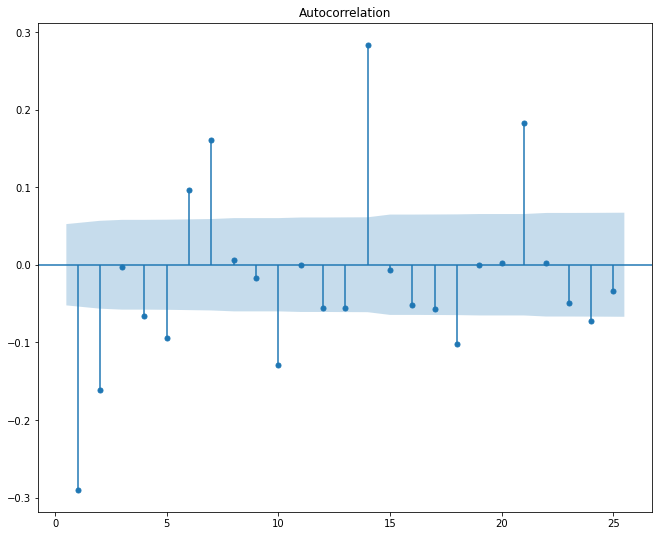

In [30]:
tsaplots.plot_acf(market_log_diff.occ, lags=25, zero=False)
plt.show()

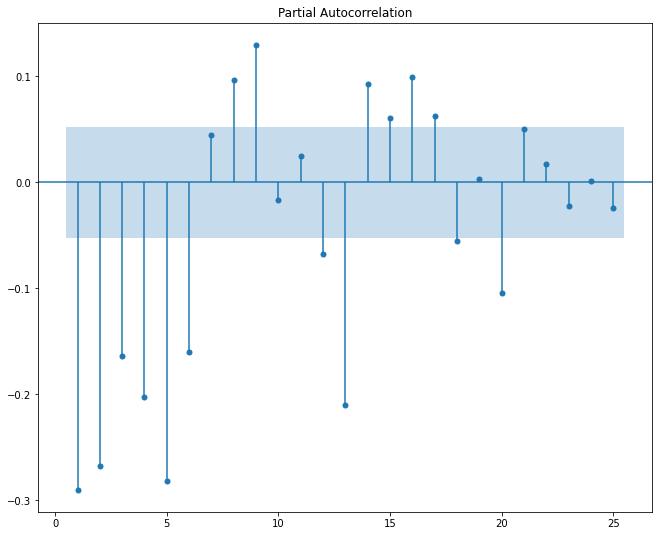

In [31]:
tsaplots.plot_pacf(market_log_diff.occ, lags=25, zero=False)
plt.show()

## 1.8.2 ARIMA Model<a id='ARIMA_Model'>
[1.0 Table of Contents](#Table_of_Contents) 

I decided I would build an ARIMA model as a baseline model using lag values discovered through a grid search process.

In [32]:
def sarimax_mse(data, sarimax_order):
    # Function to build and evaluate an SARIMAX model based on the mean squared error.
    
    # Split the data into training and test set; 80% training, 20% testing
    split= int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction SARIMAX model. 
        model = SARIMAX(past, order=sarimax_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [33]:
def sarimax_eval(dataset, p_values, d_values, q_values):
    # Grid Search process for finding the ideal p, d, and q values for an ARMA model. Needs to be adjusted for grid
    # grid searching P, D, and Q values for a SARIMAX model.
    
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = sarimax_mse(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('SARIMAX%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best SARIMAX%s MSE=%.3f' % (best_cfg, best_score))

The following plot visualizes the segmentation of the training and test data.

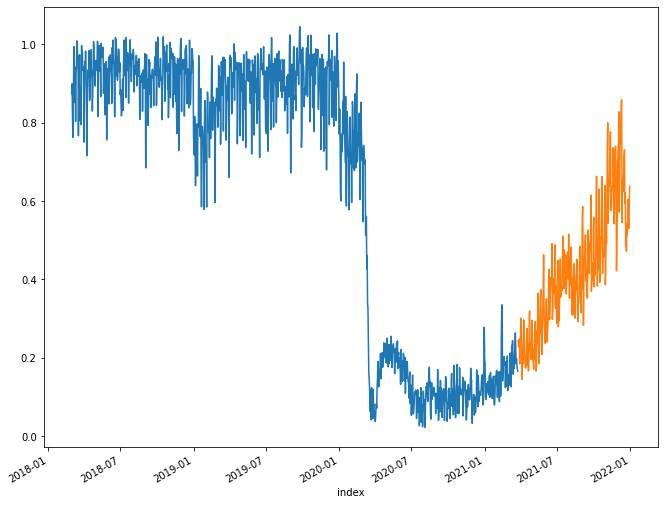

In [34]:
split= int(len(market) * 0.8) 
# Make train and test variables, with 'train, test'
train, test = market.occ[0:split], market.occ[split:len(market)]

fig, ax = plt.subplots(1,1)
train.plot(ax=ax)
test.plot(ax=ax)
plt.show()

In [35]:
# Establish a grid of values to test.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [36]:
# Run the evaluation function to find the best values in the grid.
sarimax_eval(market_log.occ, p_values, d_values, q_values)

SARIMAX(0, 0, 0) MSE=1.011
SARIMAX(0, 0, 1) MSE=0.330
SARIMAX(0, 0, 2) MSE=0.162
SARIMAX(0, 1, 0) MSE=0.040
SARIMAX(0, 1, 1) MSE=0.034
SARIMAX(0, 1, 2) MSE=0.030
SARIMAX(0, 2, 0) MSE=0.095
SARIMAX(0, 2, 1) MSE=0.040
SARIMAX(0, 2, 2) MSE=0.034
SARIMAX(1, 0, 0) MSE=0.039
SARIMAX(1, 0, 1) MSE=0.034
SARIMAX(1, 0, 2) MSE=0.030
SARIMAX(1, 1, 0) MSE=0.039
SARIMAX(1, 1, 1) MSE=0.031
SARIMAX(1, 1, 2) MSE=0.030
SARIMAX(1, 2, 0) MSE=0.074
SARIMAX(1, 2, 1) MSE=0.039
SARIMAX(1, 2, 2) MSE=0.034
SARIMAX(2, 0, 0) MSE=0.039
SARIMAX(2, 0, 1) MSE=0.031
SARIMAX(2, 0, 2) MSE=0.030
SARIMAX(2, 1, 0) MSE=0.036
SARIMAX(2, 1, 1) MSE=0.030
SARIMAX(2, 1, 2) MSE=0.029
SARIMAX(2, 2, 0) MSE=0.061
SARIMAX(2, 2, 1) MSE=0.036
SARIMAX(2, 2, 2) MSE=0.030
Best SARIMAX(2, 1, 2) MSE=0.029


In [37]:
# Create and fit the best model
model = SARIMAX(market_log.occ, order=(2,1,2), trend='c')
model_fit = model.fit()

The resultant model was used to generate a dynamic prediction.

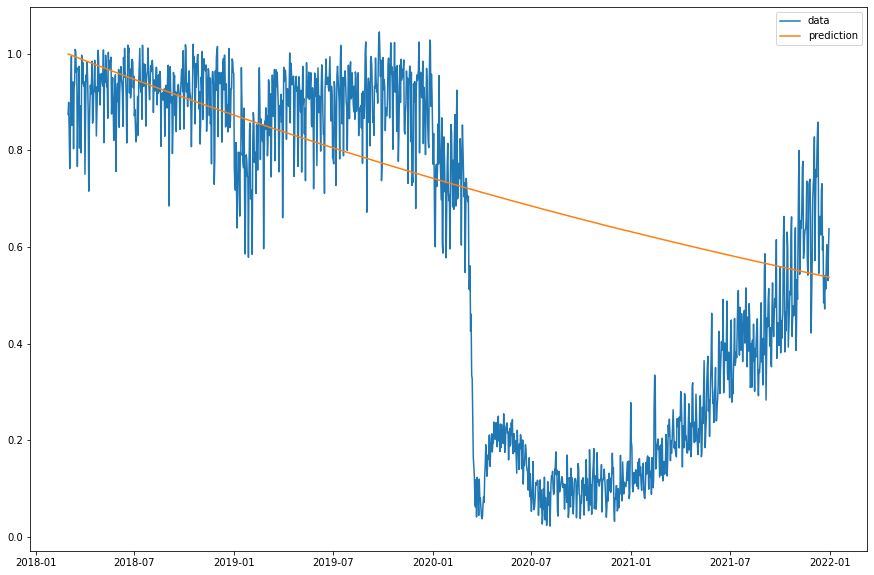

In [38]:
plt.figure(figsize=(15,10))
plt.plot(market.occ, label = 'data')
plt.plot(np.exp(model_fit.predict(dynamic=True)), label = 'prediction')
plt.legend()

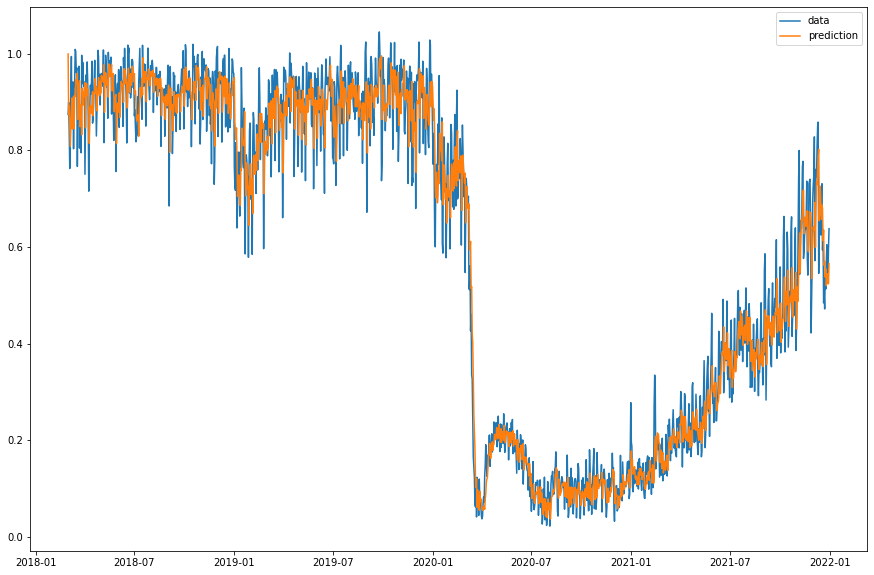

In [39]:
plt.figure(figsize=(15,10))
plt.plot(market.occ, label = 'data')
plt.plot(np.exp(model_fit.predict(dynamic=False)), label = 'prediction')
plt.legend()

## 1.8.3 Forecasting<a id='Forecasting'>
[1.0 Table of Contents](#Table_of_Contents) 

Lastly, the model was used to forecast the market occupation for the coming year.

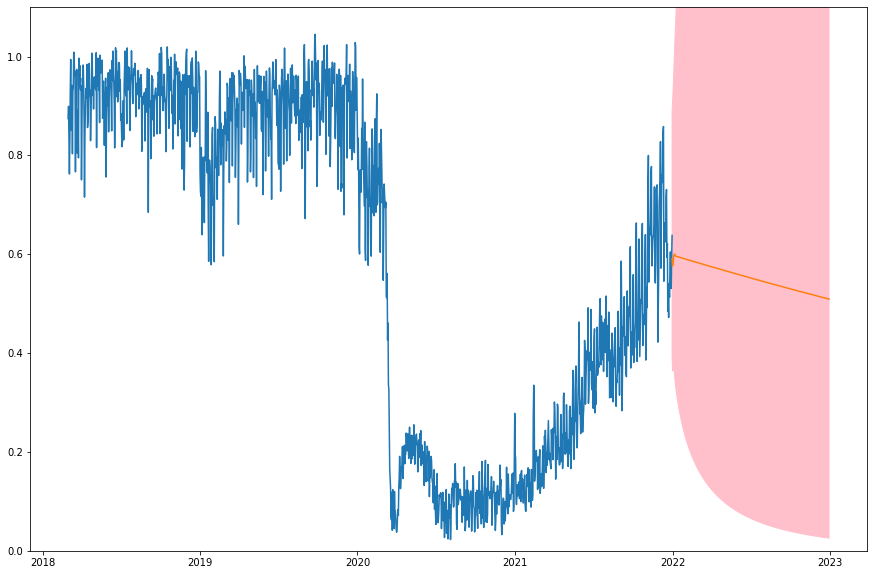

In [40]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 365
mean_forecast = model_fit.get_forecast(steps=forecast_period).predicted_mean.tolist()
date_range = pd.date_range(market_log.index[-1], periods = forecast_period, 
              freq='D').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
pred = pd.DataFrame(np.exp(mean_forecast), index = date_range)
pred.columns = [str(column) for column in pred.columns]
pred.set_index(pd.to_datetime(pred.index, infer_datetime_format=True), inplace=True)
pred = pred.rename(columns={'0': 'Forecast'})
lower_int = np.exp(model_fit.get_forecast(steps=forecast_period).conf_int()['lower occ'])
upper_int = np.exp(model_fit.get_forecast(steps=forecast_period).conf_int()['upper occ'])

# Plot your future predictions
plt.figure(figsize=(15,10))
plt.plot(market.occ)
plt.plot(pred['Forecast'])
plt.fill_between(pred.index, lower_int, upper_int, color='pink')
plt.ylim(0,1.1)
plt.show()

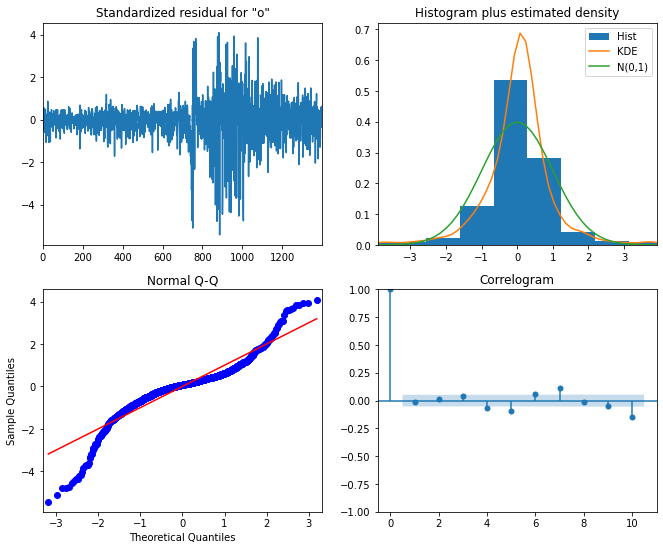

In [41]:
model_fit.plot_diagnostics()
plt.show()

In [42]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    occ   No. Observations:                 1401
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 209.630
Date:                Fri, 18 Feb 2022   AIC                           -407.261
Time:                        16:31:15   BIC                           -375.795
Sample:                             0   HQIC                          -395.498
                               - 1401                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.194      0.847      -0.002       0.002
ar.L1          0.9257      0.053     17.628      0.000       0.823       1.029
ar.L2         -0.3977      0.023    -17.525      0.000      -0.442      -0.353
ma.L1         -1.4352      0.052    -27.348      0.000      -1.538      -1.332
ma.L2          0.6145      0.040     15.472      0.000       0.537       0.692
sigma2         0.0436      0.001     49.726      0.000       0.042       0.045
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):              2037.32
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               9.45   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 1.9 Summary<a id='Summary'>
[1.0 Table of Contents](#Table_of_Contents) 

The original data set contained 1400 days of observations for the market occupation, ADR, and RevPAR with no missing values. The target feature, market occupation, might have some erroneous values considering the maximum value of 1.05, suggesting a market occupation of 105%. In this exercise, the data was left as-is; in practice, it might be better to cap the value of this feature at 1 (100%) or at least investigate the unusual values.

The features were visualized for correlation between one another. Market occupation had a strong, direct relationship with RevPAR, and a strong inverse relationship with ADR. RevPAR and ADR were strongly correlated with each other. The features were also visualized for an overall trend. All three features exhibited relative stability pre-pandemic; all were severly impacted by the pandemic; and all are showing a slow recovery to pre-pandemic levels within increasing levels of variance. There seems to be an overall seasonal increase every winter and spring, and there appears to be an autocorrelation pattern every seven days in the market occupation feature.

For preprocessing, the market occupation feature was tested for stationarity using an ADFuller and KPSS test; both tests indicated non-stationarity. The feature was transformed using a log transform, and stationarity was confirmed after taking the first difference. 

An ARIMA model was selected as a baseline model to develop. The lag values were chosen using a grid-search process and selected based on MSE values. The resultant model had values p=2, d=1, and q=2 (when fit on the log transformed data) and a test MSE value of 0.029 (using an 80-20 split). The dynamic prediction that was produced captured the overall direction of the data, but failed to capture the catastrophic drop that was induced by the pandemic shutdown. The projected mean market occupation is forecasted to decrease over the next year, with a very wide confidence interval. While it's certainly a possibility, I hypothesize that the model may be struggling to forecast due to the significant difference in data between pre and post pandemic times. 

Lastly, the model summary and diagnostics suggests that the residuals are not normally distributed, violating an important assumption of the model. I've read various opinions in support of and in disregard for the normality of the residuals in an ARMA model, which can be reviewed here: https://stats.stackexchange.com/questions/96598/what-if-the-residual-series-from-arima-not-looks-normal

and here: https://stats.stackexchange.com/questions/79400/does-arima-require-normally-distributed-errors-or-normally-distributed-input-dat

Also, the correlogram suggests that there may be some improvements to be made by incorporating seasonality into the model.

Given more time, I would have liked to:

1. Develop a full SARIMAX model.
2. Develop a model that does not have a normality assumption, such as a GARCH model with a t-distribution.
3. Possibly develop a RNN.

In hindsight I should have checked the normality of the target response before selecting a baseline model to develop, but now I know to do that next time.

# 1.10 Citations & License<a id='Citations_License'>
[1.0 Table of Contents](#Table_of_Contents) 
    
License: The code in this notebook is not available for use under any circumstance unless given explicit written and signed permission from the copyright holder, Justin R. Jimenez, copyright 2/17/2022. 
    
The following software packages were used in the development of this notebook:

@article{hunter2007matplotlib,
  title={Matplotlib: A 2D graphics environment},
  author={Hunter, John D},
  journal={Computing in science \& engineering},
  volume={9},
  number={3},
  pages={90--95},
  year={2007},
  publisher={IEEE}
}

@ARTICLE{2020NumPy-Array,
  author  = {Harris, Charles R. and Millman, K. Jarrod and van der Walt, Stéfan J and Gommers, Ralf and Virtanen, Pauli and Cournapeau, David and Wieser, Eric and Taylor, Julian and Berg, Sebastian and Smith, Nathaniel J. and Kern, Robert and Picus, Matti and Hoyer, Stephan and van Kerkwijk, Marten H. and Brett, Matthew and Haldane, Allan and Fernández del Río, Jaime and Wiebe, Mark and Peterson, Pearu and Gérard-Marchant, Pierre and Sheppard, Kevin and Reddy, Tyler and Weckesser, Warren and Abbasi, Hameer and Gohlke, Christoph and Oliphant, Travis E.},
  title   = {Array programming with {NumPy}},
  journal = {Nature},
  year    = {2020},
  volume  = {585},
  pages   = {357–362},
  doi     = {10.1038/s41586-020-2649-2}
}

@inproceedings{mckinney2010data,
  title={Data structures for statistical computing in python},
  author={McKinney, Wes and others},
  booktitle={Proceedings of the 9th Python in Science Conference},
  volume={445},
  pages={51--56},
  year={2010},
  organization={Austin, TX}
}

@article{pedregosa2011scikit,
  title={Scikit-learn: Machine learning in Python},
  author={Pedregosa, Fabian and Varoquaux, Ga{\"e}l and Gramfort, Alexandre and Michel, Vincent and Thirion, Bertrand and Grisel, Olivier and Blondel, Mathieu and Prettenhofer, Peter and Weiss, Ron and Dubourg, Vincent and others},
  journal={Journal of machine learning research},
  volume={12},
  number={Oct},
  pages={2825--2830},
  year={2011}
}

@software{michael_waskom_2017_883859,
  author       = {Michael Waskom and
                  Olga Botvinnik and
                  Drew O'Kane and
                  Paul Hobson and
                  Saulius Lukauskas and
                  David C Gemperline and
                  Tom Augspurger and
                  Yaroslav Halchenko and
                  John B. Cole and
                  Jordi Warmenhoven and
                  Julian de Ruiter and
                  Cameron Pye and
                  Stephan Hoyer and
                  Jake Vanderplas and
                  Santi Villalba and
                  Gero Kunter and
                  Eric Quintero and
                  Pete Bachant and
                  Marcel Martin and
                  Kyle Meyer and
                  Alistair Miles and
                  Yoav Ram and
                  Tal Yarkoni and
                  Mike Lee Williams and
                  Constantine Evans and
                  Clark Fitzgerald and
                  Brian and
                  Chris Fonnesbeck and
                  Antony Lee and
                  Adel Qalieh},
  title        = {mwaskom/seaborn: v0.8.1 (September 2017)},
  month        = sep,
  year         = 2017,
  publisher    = {Zenodo},
  version      = {v0.8.1},
  doi          = {10.5281/zenodo.883859},
  url          = {https://doi.org/10.5281/zenodo.883859}
}

@inproceedings{seabold2010statsmodels,
  title={statsmodels: Econometric and statistical modeling with python},
  author={Seabold, Skipper and Perktold, Josef},
  booktitle={9th Python in Science Conference},
  year={2010},
}